# **CarND-Advanced-Lane-Lines** 
***


---

In [1]:
"""
Detecting line segments on single pictures and videos which have been made by a camera in a car. 
Programm: Udacity - Self Driving Car Engineer
Project: P4 - CarND-Advanced-Lane-Lines
Author: Daniel Gattringer (gada1982) 
"""

#importing some useful packages
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline



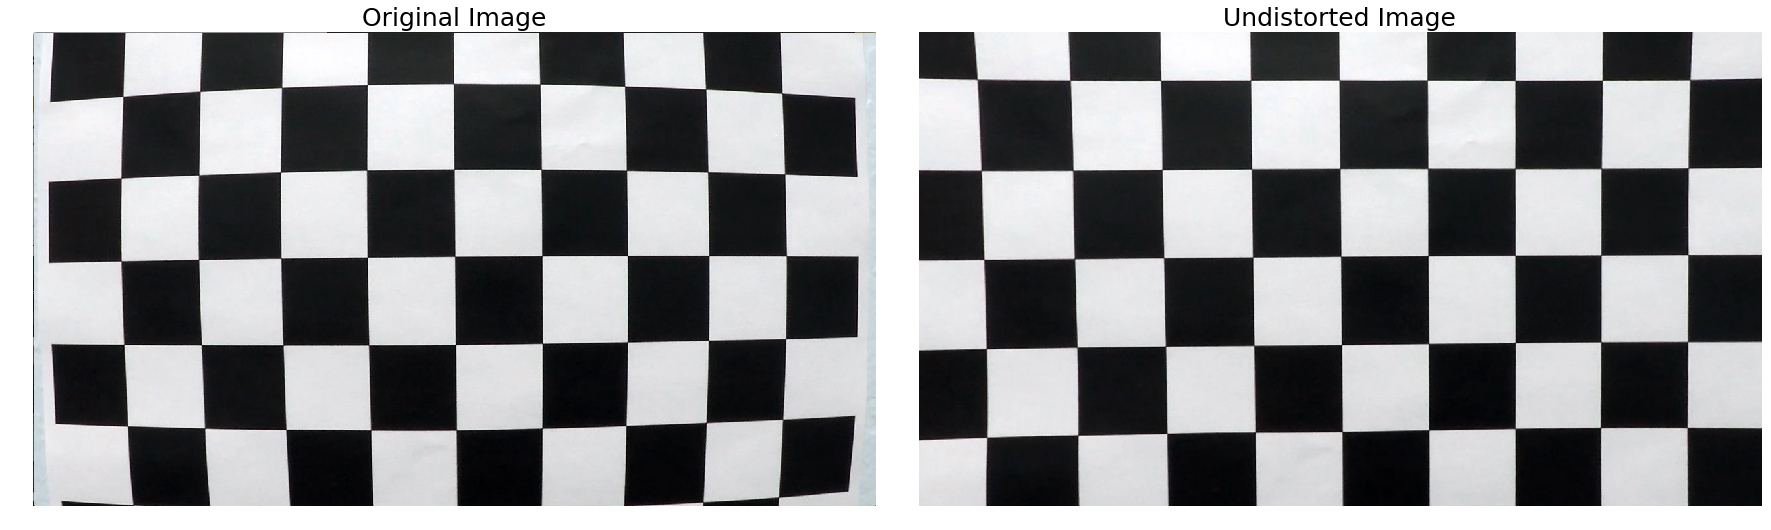

In [2]:
# Code taken from https://github.com/udacity/CarND-Camera-Calibration

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = 'camera_cal_corners_found/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)

# Read in an image
image = cv2.imread('camera_cal/calibration1.jpg')

def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

image_undist = cal_undistort(image, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.axis('off')
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(image_undist)
ax2.set_title('Undistorted Image', fontsize=25)
ax2.axis('off')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

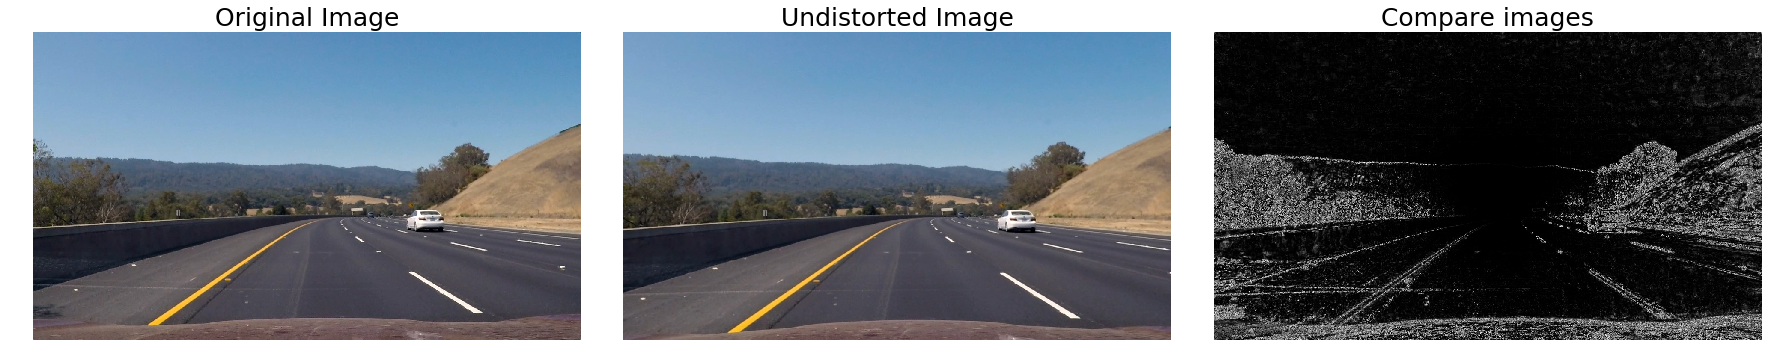

In [3]:
# Distort test_images

# read in one test image 
image = mpimg.imread('test_images/test3.jpg')

image_undist = cal_undistort(image, objpoints, imgpoints)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.axis('off')
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(image_undist)
ax2.axis('off')
ax2.set_title('Undistorted Image', fontsize=25)
ax3.imshow(np.sum((image - image_undist)**2,axis=2),cmap='gray')
ax3.axis('off')
ax3.set_title('Compare images', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

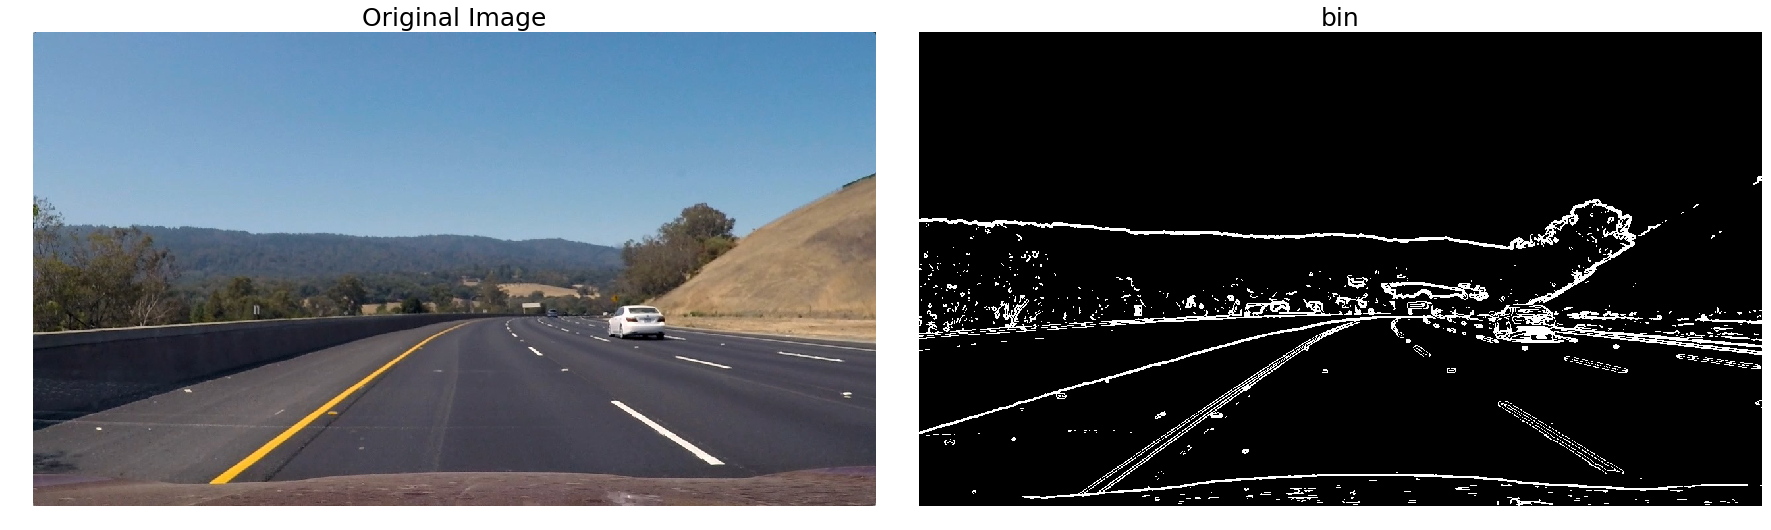

In [14]:
# Create a binary image for one image

def apply_gaussian_blur(image, kernel):
    gaussian_blur_image = cv2.GaussianBlur(image,(kernel,kernel),0)
    return gaussian_blur_image

def abs_sobel_thresh(img, orient, sobel_kernel, thresh):
    # Apply the following steps to img
    # 1) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1)
        
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return grad_binary

def mag_thresh(image, sobel_kernel, mag_thresh):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)    
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*gradmag/np.max(gradmag))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return mag_binary

# Choose a Sobel kernel size
ksize = 5 # Choose a larger odd number to smooth gradient measurements

# read in one test image 
image = mpimg.imread('test_images/test3.jpg')

image_undist = cal_undistort(image, objpoints, imgpoints)

image_gaussian_blur = apply_gaussian_blur(image_undist, 5)

# Apply each of the thresholding functions
mag_binary = mag_thresh(image_gaussian_blur, sobel_kernel=ksize, mag_thresh=(25, 100))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.axis('off')
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(mag_binary, cmap='gray')
ax2.axis('off')
ax2.set_title('bin', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

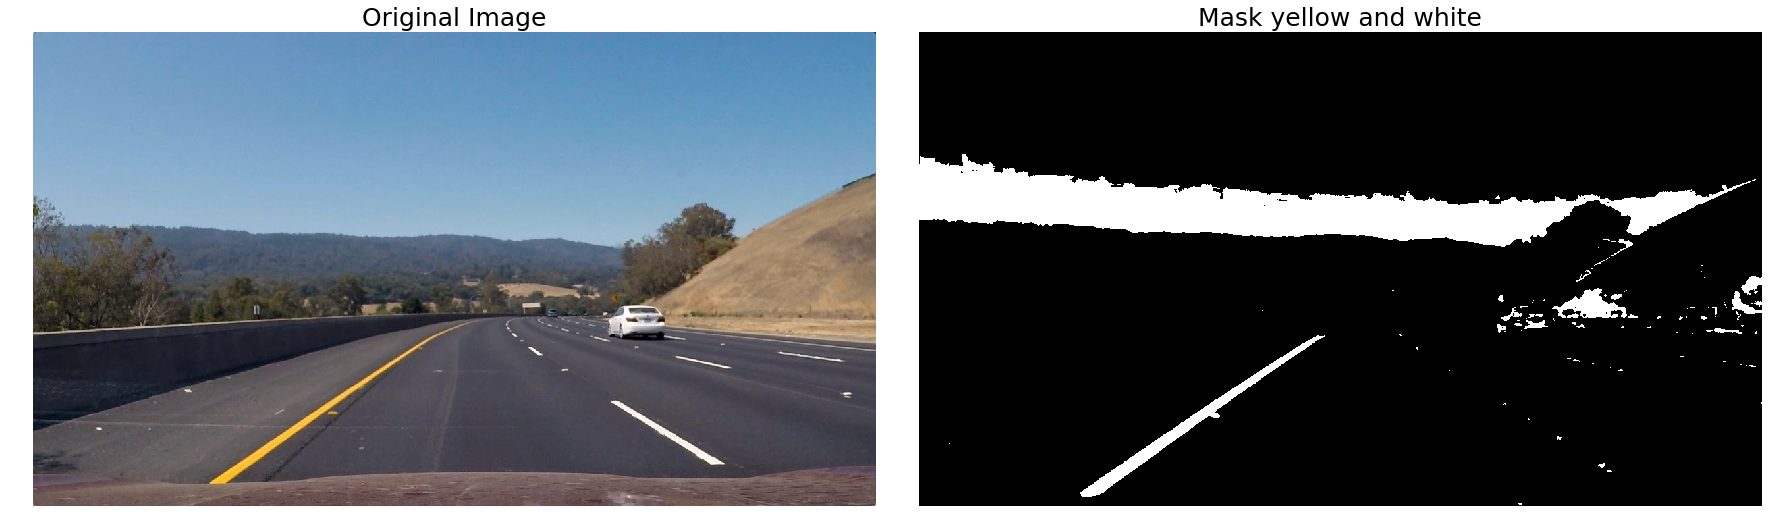

In [15]:
# Apply Color mask

def get_color_mask(img):
    
    image_hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    
    # White - TODO test different values
    hsv_white_l  = np.array([ 20,   0,   180])
    hsv_white_h = np.array([ 255,  80, 255])
    
    # Mask for white lanes
    mask_white = cv2.inRange(image_hsv, hsv_white_l, hsv_white_h)
    
    # Yellow - TODO test different values
    hsv_yellow_l  = np.array([ 0,  100,  100])
    hsv_yellow_h = np.array([ 50, 255, 255])
    
    # Mask for yellow lanes
    mask_yellow = cv2.inRange(image_hsv, hsv_yellow_l, hsv_yellow_h)
    
    mask_white_yellow = cv2.bitwise_or(mask_white, mask_yellow)
    
    return mask_white_yellow

# read in one test image 
image = mpimg.imread('test_images/test3.jpg')

image_undist = cal_undistort(image, objpoints, imgpoints)

image_gaussian_blur = apply_gaussian_blur(image_undist, 5)

mask_yellow_white = get_color_mask(image_gaussian_blur)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.axis('off')
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(mask_yellow_white, cmap='gray')
ax2.axis('off')
ax2.set_title('Mask yellow and white', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

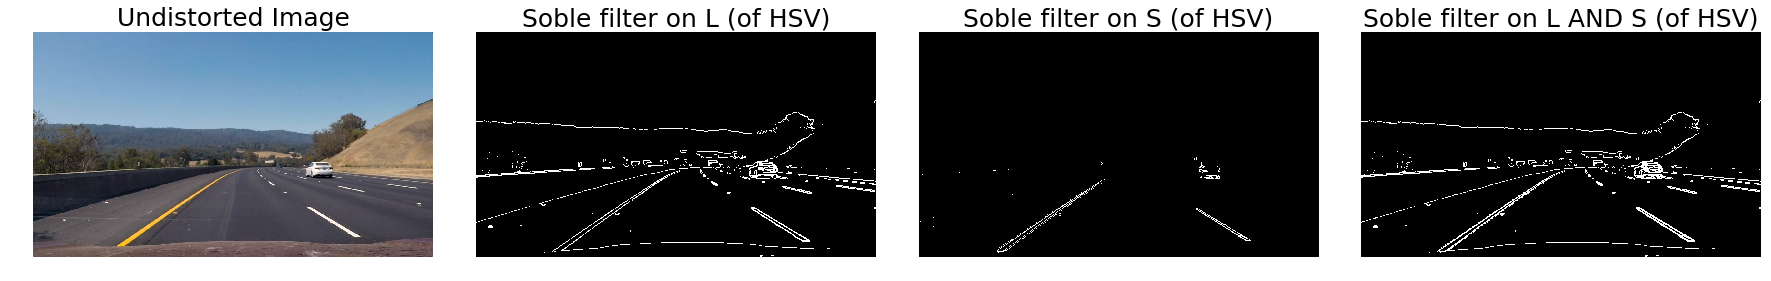

In [18]:
# Apply sobel filters
def get_sobel_mask(img):
    # Get image in HLS Color Space
    image_hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    
    # Get L channel
    image_hls_l = image_hls[:,:,1]
    ksize = 5
    thresh = (50,225)
    gradx = abs_sobel_thresh(image_hls_l, orient='x', sobel_kernel = ksize, thresh = thresh)
    grady = abs_sobel_thresh(image_hls_l, orient='y', sobel_kernel = ksize, thresh = thresh)
    
    filter_hls_l = np.copy(cv2.bitwise_or(gradx, grady))
    
    # Get S channel
    image_hls_s = image_hls[:,:,2]
    gradx = abs_sobel_thresh(image_hls_s, orient='x', sobel_kernel = ksize, thresh = thresh)
    grady = abs_sobel_thresh(image_hls_s, orient='y', sobel_kernel = ksize, thresh = thresh)
    
    filter_hls_s = np.copy(cv2.bitwise_or(gradx, grady))
    
    return filter_hls_l, filter_hls_s

def get_combined_sobel_mask(image):
    filter_hls_l, filter_hls_s = get_sobel_mask(image)
    filter_hls_l_s = cv2.bitwise_or(filter_hls_l,filter_hls_s)
    return filter_hls_l_s

# read in one test image 
image = mpimg.imread('test_images/test3.jpg')

image_undist = cal_undistort(image, objpoints, imgpoints)

image_gaussian_blur = apply_gaussian_blur(image_undist, 5)

filter_hls_l, filter_hls_s = get_sobel_mask(image_gaussian_blur)

filter_hls_l_s = get_combined_sobel_mask(image_gaussian_blur)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 20))
f.tight_layout()
ax1.imshow(image)
ax1.axis('off')
ax1.set_title('Undistorted Image', fontsize=25)
ax2.imshow(filter_hls_l, cmap='gray')
ax2.axis('off')
ax2.set_title('Soble filter on L (of HSV)', fontsize=25)
ax3.imshow(filter_hls_s, cmap='gray')
ax3.axis('off')
ax3.set_title('Soble filter on S (of HSV)', fontsize=25)
ax4.imshow(filter_hls_l_s, cmap='gray')
ax4.axis('off')
ax4.set_title('Soble filter on L AND S (of HSV)', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

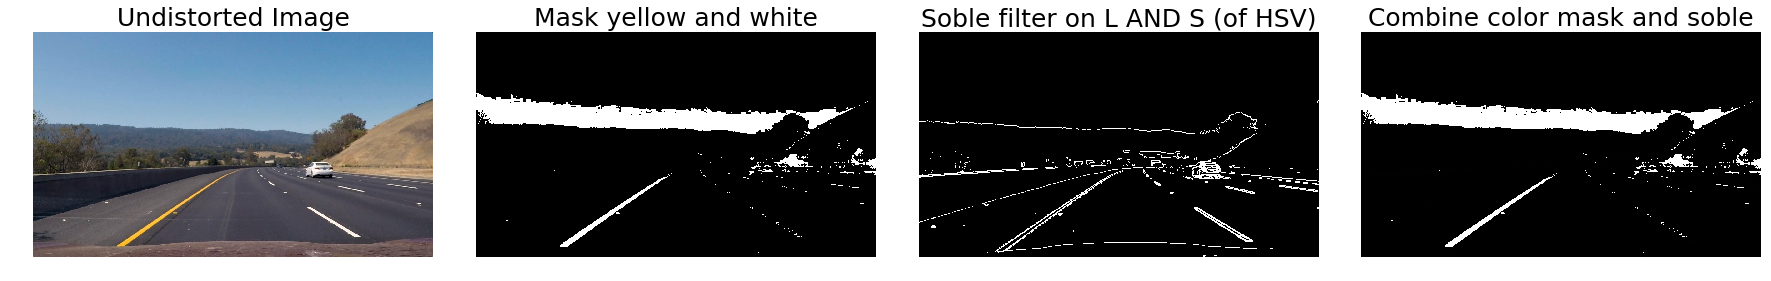

In [21]:
# Combine Color mask (white and yellow) and sobel filters (x,y) on HLS (l and s used)
# read in one test image 
image = mpimg.imread('test_images/test3.jpg')

image_undist = cal_undistort(image, objpoints, imgpoints)

image_gaussian_blur = apply_gaussian_blur(image_undist, 5)

mask_yellow_white = get_color_mask(image)

filter_hls_l_s = get_combined_sobel_mask(image_gaussian_blur)

image_filter_comb = cv2.bitwise_or(filter_hls_l_s, mask_yellow_white)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 20))
f.tight_layout()
ax1.imshow(image)
ax1.axis('off')
ax1.set_title('Undistorted Image', fontsize=25)
ax2.imshow(mask_yellow_white, cmap='gray')
ax2.axis('off')
ax2.set_title('Mask yellow and white', fontsize=25)
ax3.imshow(filter_hls_l_s, cmap='gray')
ax3.axis('off')
ax3.set_title('Soble filter on L AND S (of HSV)', fontsize=25)
ax4.imshow(image_filter_comb, cmap='gray')
ax4.axis('off')
ax4.set_title('Combine color mask and soble', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


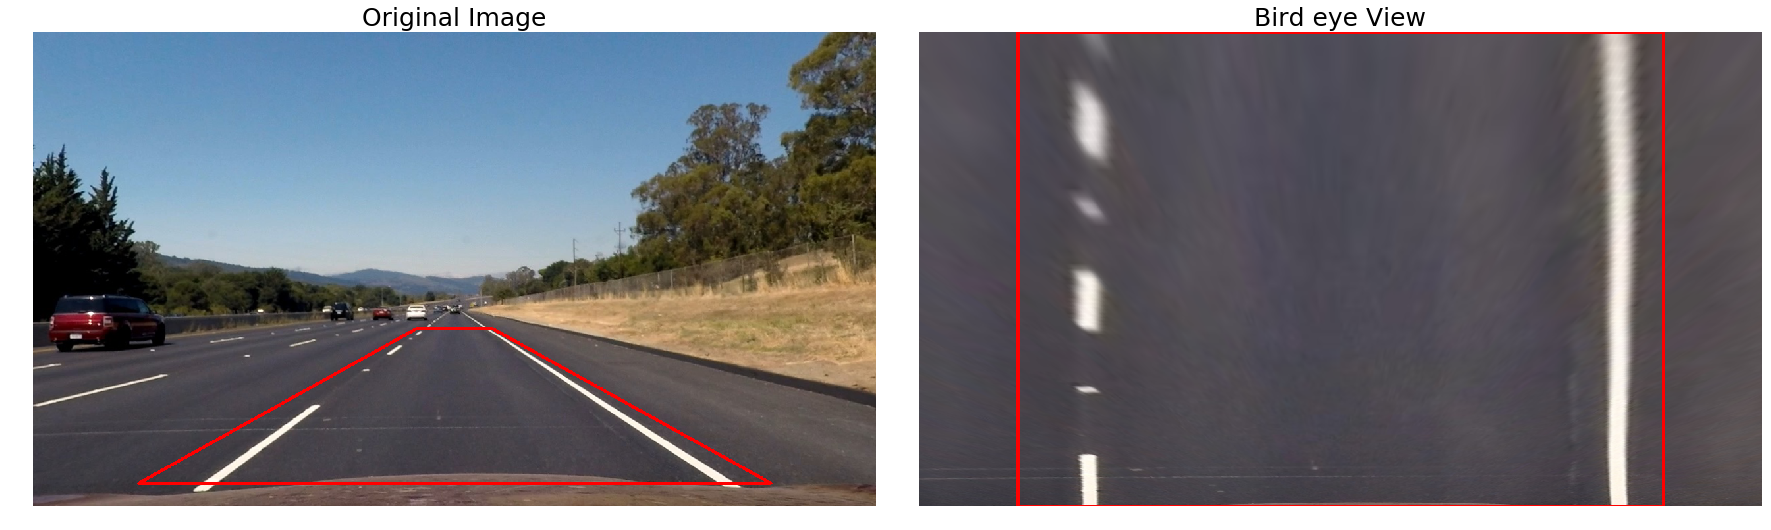

In [22]:
# Apply perspective transform to get Bird-Eye-View
# read in one test image 
image = mpimg.imread('test_images/straight_lines2.jpg')

# undistort image
image = cal_undistort(image, objpoints, imgpoints)

# Get the size of the image
image_size = np.shape(image)

mid_y_points = int(np.uint(image_size[0] / 1.6))
bottom_points = int(np.uint(image_size[0]) / 1.05)
center_image = int(np.uint(image_size[1]/2))
# TODO changenames
ctl_window = int(center_image - (image_size[1] / 2) * 0.09)
ctr_window = int(center_image + (image_size[1] / 2) * 0.09)
cbl_window = int(center_image - (image_size[1] / 2) * 0.75)
cbr_window = int(center_image + (image_size[1] / 2) * 0.75)

points_src = [[cbl_window,bottom_points],[cbr_window,bottom_points],[ctr_window,mid_y_points],[ctl_window,mid_y_points]]
points_dst = [[150,image_size[0]],[image_size[1]-150,image_size[0]],[image_size[1]-150,0],[150,0]]
points_src_float = np.float32(points_src)
points_dst_float = np.float32(points_dst)

points_src_arr = np.array(points_src)
points_dst_arr = np.array(points_dst)


def warp_image(image, points_src_float, points_dst_float):
    image_size = np.shape(image)
    image_size = (image_size[1],image_size[0])
    # Apply perspective transform
    M = cv2.getPerspectiveTransform(points_src_float, points_dst_float)
    warped = cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(points_dst_float, points_src_float)

    return warped, M, Minv

warped, M_warp, M_inv_warp = warp_image(image, points_src_float, points_dst_float)
cv2.polylines(image, [points_src_arr], True, color = (255,0,0), thickness = 3)
cv2.polylines(warped, [points_dst_arr], True, color = (255,0,0), thickness = 3)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)   
ax1.axis('off')
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(warped)
ax2.axis('off')
ax2.set_title('Bird eye View', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

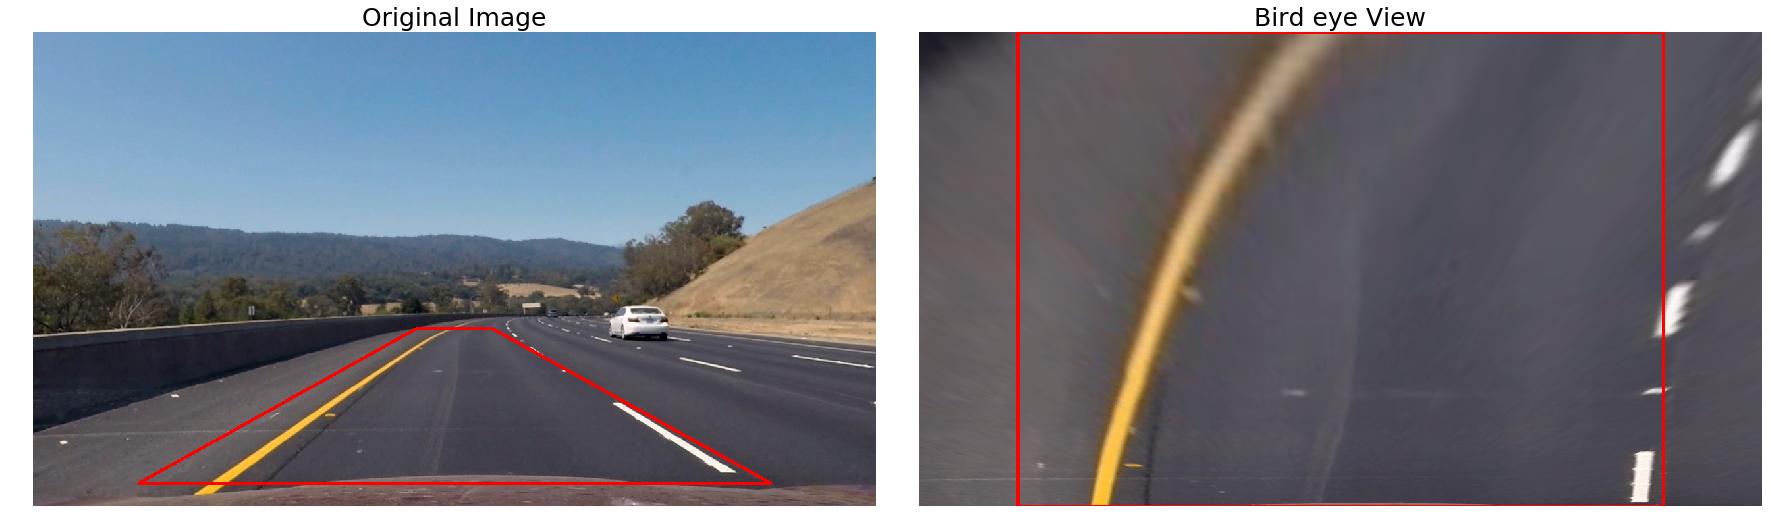

In [23]:
# Apply perspective transform to get Bird-Eye-View
# read in one test image 
image = mpimg.imread('test_images/test3.jpg')

# undistort image
image = cal_undistort(image, objpoints, imgpoints)

warped, M_warp, M_inv_warp = warp_image(image, points_src_float, points_dst_float)
cv2.polylines(image, [points_src_arr], True, color = (255,0,0), thickness = 3)
cv2.polylines(warped, [points_dst_arr], True, color = (255,0,0), thickness = 3)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.axis('off')
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(warped)
ax2.axis('off')
ax2.set_title('Bird eye View', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

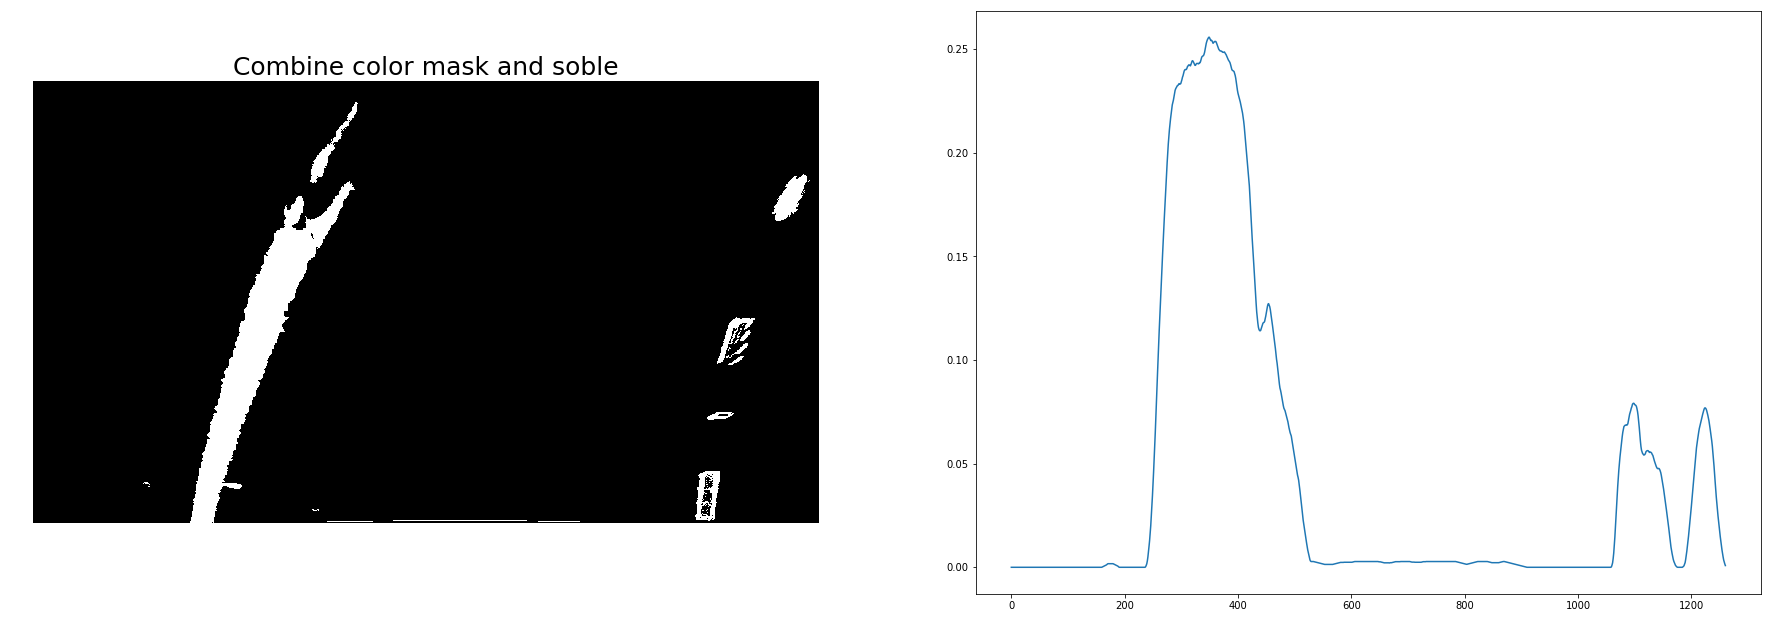

In [58]:
# Find lanes

def get_moving_average(data, N):
    mov_avg = np.convolve(data, np.ones((N,))/N, mode='valid')
    return mov_avg



# Combine Color mask (white and yellow) and sobel filters
# read in one test image 
#image = mpimg.imread('test_images/straight_lines2.jpg')
image = mpimg.imread('test_images/test3.jpg')

def get_comb_filter(image):
    apply_gaussian = 0
    # undistort image
    image = cal_undistort(image, objpoints, imgpoints)
    
    if apply_gaussian == 1:
        image = apply_gaussian_blur(image, 5)
    
    warped, M_warp, M_inv_warp = warp_image(image, points_src_float, points_dst_float)

    mask_yellow_white = get_color_mask(warped)
    
    filter_hls_l_s = get_combined_sobel_mask(warped)
    if apply_gaussian == 1:
        filter_hls_l_s = apply_gaussian_blur(filter_hls_l_s, 25)

    #image_filter_comb = cv2.bitwise_or(filter_hls_l_s_blur, mask_yellow_white)
    image_filter_comb = np.zeros_like(filter_hls_l_s)
    image_filter_comb[(mask_yellow_white>=.5)|(filter_hls_l_s>=.5)]=1
    
    mean_of_lane = np.mean(image_filter_comb, axis=0)
    mean_of_lane = get_moving_average(mean_of_lane, 20)
    
    return image_filter_comb, mean_of_lane

image_filter_comb, mean_of_lane = get_comb_filter(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(image_filter_comb, cmap='gray')   
ax1.axis('off')
ax1.set_title('Combine color mask and soble', fontsize=25)
ax2.plot(mean_of_lane)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

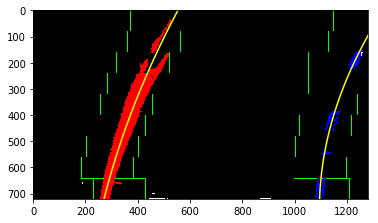

In [59]:
# Code from Lesson Finding the lines

import numpy as np
import cv2
import matplotlib.pyplot as plt

def find_first(binary_warped, do_print):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, image_filter_comb.shape[0]-1, image_filter_comb.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if do_print == 1:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return leftx, left_fit, left_fitx, right_fit, rightx, right_fitx, ploty, left_fit_cr, right_fit_cr
    

# Combine Color mask (white and yellow) and sobel filters
# read in one test image 
#image = mpimg.imread('test_images/straight_lines2.jpg')
image = mpimg.imread('test_images/test3.jpg')

image_filter_comb, mean_of_lane = get_comb_filter(image)    
leftx, left_fit, left_fitx, right_fit, rightx, right_fitx, ploty, left_fit_cr, right_fit_cr = find_first(image_filter_comb, 1)


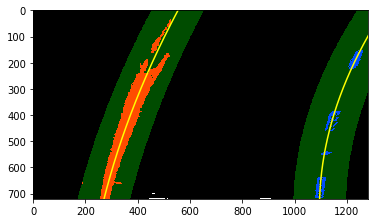

In [60]:
# Code from Lesson Finding the lines

margin = 100

def find_next(binary_warped, left_fit, right_fit, do_print):
    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if do_print == 1:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((image_filter_comb, image_filter_comb, image_filter_comb)) * 255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return leftx, left_fit, left_fitx, right_fit, rightx, right_fitx, ploty, left_fit_cr, right_fit_cr

image = mpimg.imread('test_images/test3.jpg')

image_filter_comb, mean_of_lane = get_comb_filter(image) 

leftx, left_fit, left_fitx, right_fit, rightx, right_fitx, ploty, left_fit_cr, right_fit_cr = find_next(image_filter_comb, left_fit, right_fit, 1)

In [61]:
# Code from lesson
# Calculate curvature pix

def calculate_curvature_pix(left_fit, right_fit, ploty):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    mean_curverad = (left_curverad + right_curverad) / 2
    
    return left_curverad, right_curverad, mean_curverad

left_curverad, right_curverad, mean_curverad = calculate_curvature_pix(left_fit, right_fit, ploty)

print('Left line curvature (radius pix): ', left_curverad)
print('Right line curvature (radius pix): ', right_curverad)
print('Mean curvature (radius m): ', mean_curverad)
# Example values: 1926.74 1908.48

Left line curvature (radius pix):  2824.23653114
Right line curvature (radius pix):  1173.15702181
Mean curvature (radius m):  1998.69677647


In [62]:
# Code from lesson
# Calculate curvature real world

# TODO rework
def calculate_curvature_rw(binary_warped, left_fit_cr, right_fit_cr):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # first we calculate the intercept points at the bottom of our image
    left_intercept = left_fit[0] * image_size[0] ** 2 + left_fit[1] * image_size[0] + left_fit[2]
    right_intercept = right_fit[0] * image_size[0] ** 2 + right_fit[1] * image_size[0] + right_fit[2]

    # Next take the difference in pixels between left and right interceptor points
    road_width_in_pixels = right_intercept - left_intercept
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    mean_curverad = (left_curverad + right_curverad) / 2
    
    calculated_center = (left_intercept + right_intercept) / 2.0
    
    lane_deviation = round((calculated_center - image_size[1] / 2.0) * xm_per_pix, 2)
    
    return left_curverad, right_curverad, mean_curverad, lane_deviation

#left_curverad, right_curverad, lane_deviation = calculate_curvature_rw_old(image_filter_comb, left_fit, right_fit, leftx, rightx)

left_curverad, right_curverad, mean_curverad, lane_deviation = calculate_curvature_rw(image_filter_comb, left_fit_cr, right_fit_cr)
print('Left line curvature (radius m): ', left_curverad)
print('Right line curvature (radius m): ', right_curverad)
print('Mean curvature (radius m): ', mean_curverad)
print('Lane center (m): ', lane_deviation)
# Example values: 1926.74 1908.48

Left line curvature (radius m):  846.676401307
Right line curvature (radius m):  384.719314767
Mean curvature (radius m):  615.697858037
Lane center (m):  0.23


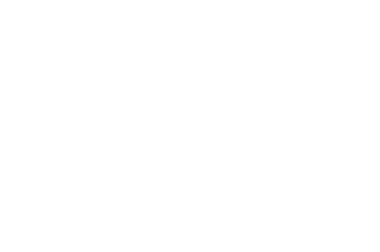

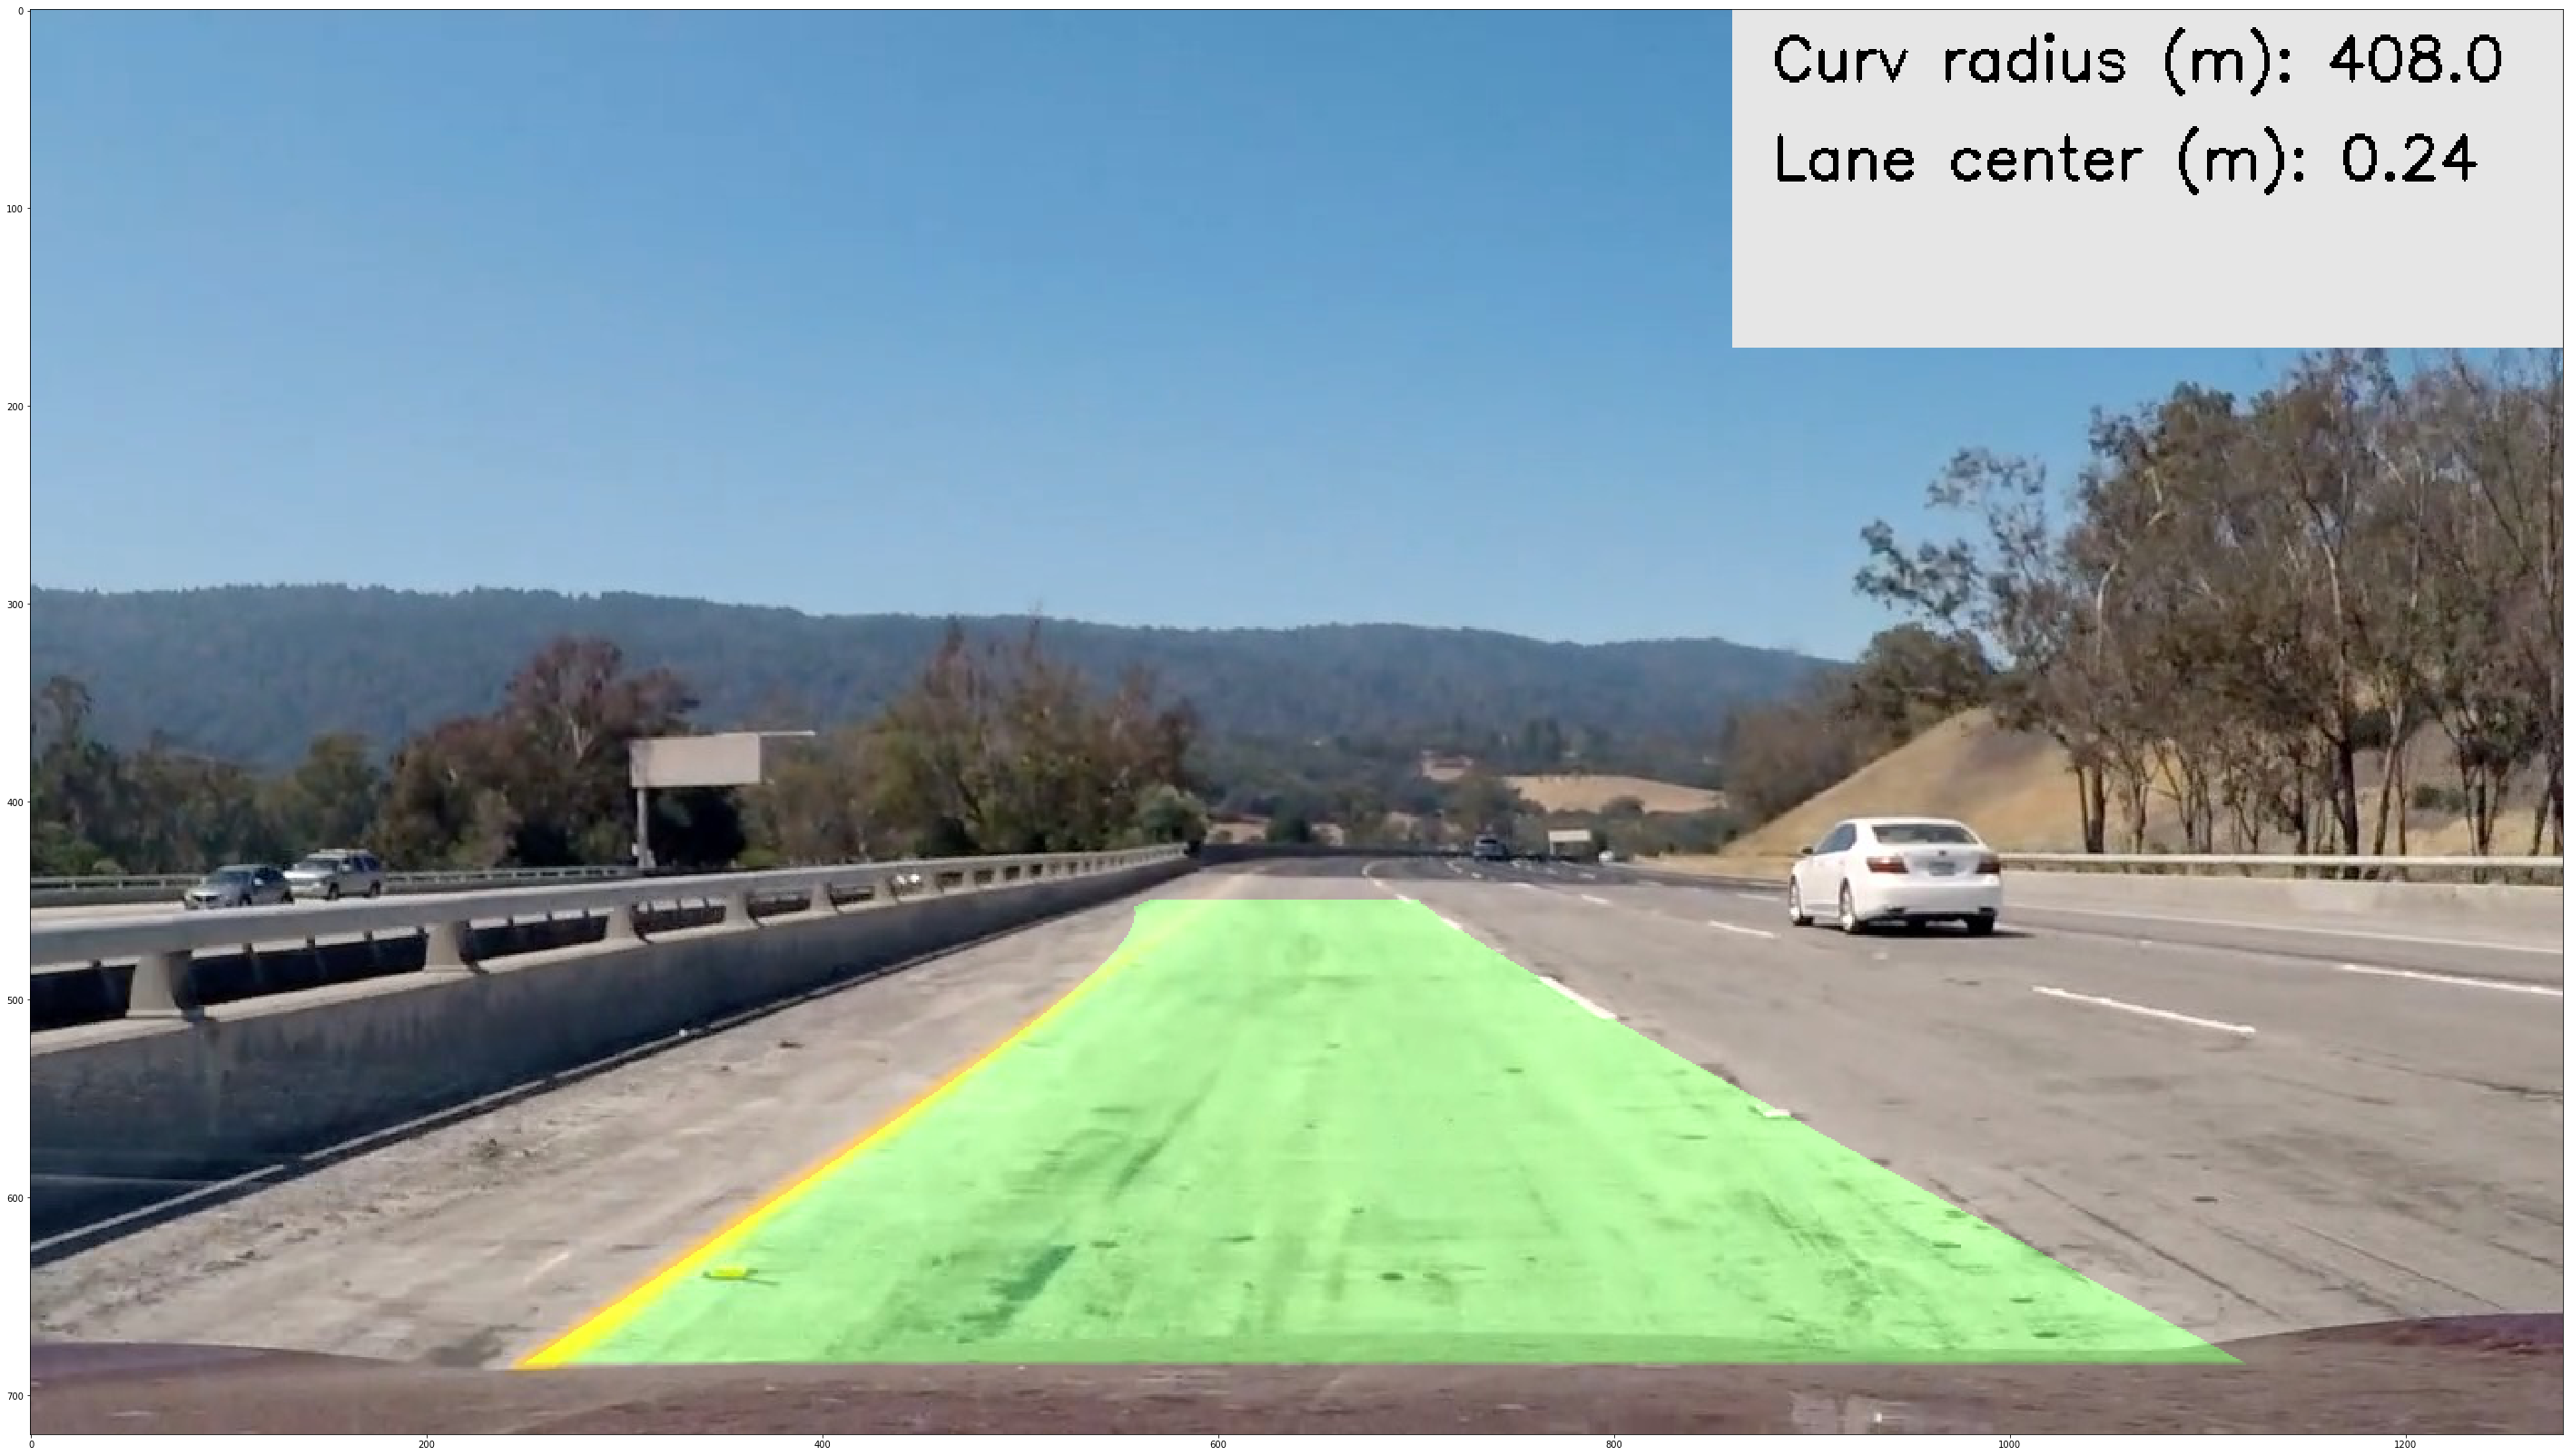

In [63]:
# Code from lesson

count = 0
left_fit = 0
right_fit = 0

# Create an image to draw the lines on
def generate_processed_image(image):
    global count
    global left_fit, right_fit
    
    image_filter_comb, mean_of_lane = get_comb_filter(image)
    
    warp_zero = np.zeros_like(image_filter_comb).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    if count == 0:
        leftx, left_fit, left_fitx, right_fit, rightx, right_fitx, ploty, left_fit_cr, right_fit_cr = find_first(image_filter_comb, 0)
        count += 1
    else:
        leftx, left_fit, left_fitx, right_fit, rightx, right_fitx, ploty, left_fit_cr, right_fit_cr = find_next(image_filter_comb, left_fit, right_fit, 0)
        
    # Recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, image_filter_comb.shape[0]-1, image_filter_comb.shape[0] )
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv_warp, (image.shape[1], image.shape[0])) 
    #Combine the result with the original image
    result_1 = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    left_curverad, right_curverad, mean_curverad, lane_deviation = calculate_curvature_rw(image_filter_comb, left_fit_cr, right_fit_cr)
    curv_mean = 'Curv radius (m): ' + str(round(mean_curverad, 0))
    text_lane = 'Lane center (m): ' + str(lane_deviation)
    points_dst = [[image_size[1]-420,image_size[0]-550],[image_size[1],image_size[0]-550],[image_size[1],0],[image_size[1]-420,0]]
    points_dst_arr = np.array(points_dst)

    cv2.fillPoly(result_1, [points_dst_arr], (230,230,230))
    #cv2.putText(result_1,"Hello World!!!", (image_size[1]-380,20), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result_1,curv_mean,(image_size[1]-400,35), font, 1,(0,0,0),2)
    cv2.putText(result_1,text_lane,(image_size[1]-400,85), font, 1,(0,0,0),2)
    
    return result_1

do_test = 1

if do_test == 1:
    #image = mpimg.imread('test_images/straight_lines1.jpg')
    image = mpimg.imread('own_test_images/project/own_test3.jpg')
    result = generate_processed_image(image)

    count = 0

    plt.axis('off')
    plt.figure(figsize=(50,50))
    plt.imshow(result)

In [64]:
# Test on video
import moviepy
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%load_ext autoreload
%autoreload 2

output_file = 'processed_project_video.mp4'
input_file = 'project_video.mp4'

count = 0
clip = VideoFileClip(input_file)
out_clip = clip.fl_image(generate_processed_image) 
out_clip.write_videofile(output_file, audio=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[MoviePy] >>>> Building video processed_project_video.mp4
[MoviePy] Writing video processed_project_video.mp4


100%|█████████▉| 1260/1261 [11:54<00:00,  1.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed_project_video.mp4 



In [17]:
# Test on video
import moviepy
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%load_ext autoreload
%autoreload 2

output_file = 'processed_challenge_video.mp4'
input_file = 'challenge_video.mp4'

count = 0
clip = VideoFileClip(input_file)
out_clip = clip.fl_image(generate_processed_image) 
out_clip.write_videofile(output_file, audio=False)

Frame1
[MoviePy] >>>> Building video processed_challenge_video.mp4
[MoviePy] Writing video processed_challenge_video.mp4


100%|██████████| 485/485 [04:23<00:00,  1.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed_challenge_video.mp4 



In [18]:
# Test on video
import moviepy
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%load_ext autoreload
%autoreload 2

output_file = 'processed_harder_challenge_video.mp4'
input_file = 'harder_challenge_video.mp4'

count = 0
clip = VideoFileClip(input_file)
out_clip = clip.fl_image(generate_processed_image) 
out_clip.write_videofile(output_file, audio=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Frame1
[MoviePy] >>>> Building video processed_harder_challenge_video.mp4
[MoviePy] Writing video processed_harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [11:21<00:00,  1.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed_harder_challenge_video.mp4 

